Determining the Impact of COVID-19 on the 2020 Presidential Election

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# Subtask 1: 
Data Cleaning and Tracking Changes in Voter Behavior from 2016 to 2020	

In [ ]:
county_statistics = pd.read_csv("/content/drive/MyDrive/MSSP607Final/county_statistics.csv")

In [ ]:
len(county_statistics)

4867

In [ ]:
#filter out counties without data because they can't help us answer the question
known_stats = county_statistics[county_statistics["cases"].notna()]
known_stats = known_stats[known_stats["total_votes20"].notna()]
known_stats = known_stats[known_stats["total_votes16"].notna()]
known_stats = known_stats[known_stats["percentage20_Donald_Trump"].notna()]

In [ ]:
# convert "percentage" columns to actual percentages
known_stats["percentage16_Donald_Trump"] = known_stats["percentage16_Donald_Trump"].apply(lambda x: x*100)
known_stats["percentage20_Donald_Trump"] = known_stats["percentage20_Donald_Trump"].apply(lambda x: x*100)
known_stats["percentage16_Hillary_Clinton"] = known_stats["percentage16_Hillary_Clinton"].apply(lambda x: x*100)
known_stats["percentage20_Joe_Biden"] = known_stats["percentage20_Joe_Biden"].apply(lambda x: x*100)

In [ ]:
known_stats["raw_diff_16_to_20"] = known_stats["votes20_Donald_Trump"] - known_stats["votes16_Donald_Trump"]
known_stats["percent_diff_16_to_20"] = known_stats["percentage20_Donald_Trump"] - known_stats["percentage16_Donald_Trump"]

In [ ]:
len(known_stats)

3046

In [ ]:
known_stats.state.value_counts()

TX    254
GA    159
KY    120
MO    114
KS    105
IL    101
NC    100
IA     99
TN     95
VA     95
NE     93
IN     92
OH     88
MN     87
MI     83
MS     82
OK     77
AR     75
WI     72
FL     67
AL     67
PA     67
SD     65
CO     64
LA     63
NY     62
CA     58
MT     56
WV     55
ND     53
SC     46
ID     44
WA     39
OR     36
NM     32
UT     29
WY     23
MD     23
NJ     21
NV     17
AZ     15
VT     11
ME     10
MA      8
CT      7
NH      6
HI      4
DE      3
RI      3
DC      1
Name: state, dtype: int64

# Subtask 2:
Integrating longitudinal COVID-19 dataset. Focus on last month before election when grouping and looking at effect.

In [ ]:
covid_county = pd.read_csv("/content/drive/MyDrive/MSSP607Final/covid_us_county.csv")

In [ ]:
covid_county["date"] = pd.to_datetime(covid_county["date"], utc=True)

In [ ]:
only_month_before = covid_county.loc[((covid_county["date"].dt.month == 10) | (covid_county["date"].dt.month == 11)) & (covid_county["date"].dt.day == 2)]

In [ ]:
covid_long = only_month_before.pivot_table(index=["county", "state_code"], columns="date", values=["cases", "deaths"], )

In [ ]:
merged_data = covid_long.merge(known_stats, how='right', right_on=["county", "state"], left_on=["county", "state_code"])

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [ ]:
merged_data.head()

,county,"(cases, 2020-10-02 00:00:00+00:00)","(cases, 2020-11-02 00:00:00+00:00)","(deaths, 2020-10-02 00:00:00+00:00)","(deaths, 2020-11-02 00:00:00+00:00)",Unnamed: 0,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,raw_diff_16_to_20,percent_diff_16_to_20
0,Abbeville,606.0,806.0,13.0,17.0,0,SC,62.9,34.6,10724.0,6742.0,3712.0,66.1,33.0,12433.0,8215.0,4101.0,34.223334,-82.461707,805.0,17.0,24788.0,12044.0,12744.0,1.3,68.9,27.6,0.1,0.3,0.0,19452.0,35254.0,2259.0,19234.0,799.0,22.7,32.1,27.2,20.7,20.8,10.6,20.7,78.3,11.1,0.5,1.8,1.8,6.5,25.8,9505.0,78.8,13.3,7.8,0.1,9.4,1473.0,3.2
1,Acadia,2982.0,3183.0,99.0,102.0,1,LA,77.3,20.6,27386.0,21159.0,5638.0,79.5,19.1,28425.0,22596.0,5443.0,30.295065,-92.414197,3182.0,102.0,62607.0,30433.0,32174.0,2.4,77.5,17.6,0.1,0.1,0.0,45197.0,40492.0,2544.0,21591.0,1002.0,21.5,27.6,27.6,16.9,25.7,15.0,14.8,83.2,10.3,0.2,1.6,2.2,2.5,27.6,24982.0,80.0,12.1,7.6,0.3,8.9,1437.0,2.2
2,Accomack,1183.0,1229.0,19.0,19.0,2,VA,54.5,42.8,15755.0,8582.0,6737.0,54.2,44.7,16938.0,9172.0,7578.0,37.767072,-75.632346,1227.0,19.0,32840.0,16079.0,16761.0,8.8,60.3,28.3,0.3,0.7,0.0,24408.0,42260.0,2253.0,24266.0,1564.0,19.8,31.8,31.1,17.7,18.8,15.1,17.3,80.0,10.6,0.5,2.6,1.8,4.5,22.0,13837.0,74.6,18.1,7.1,0.2,5.4,590.0,-0.3
3,Ada,13343.0,17499.0,148.0,181.0,3,ID,47.9,38.7,195587.0,93748.0,75676.0,50.4,46.5,259389.0,130699.0,120539.0,43.452658,-116.241552,17451.0,181.0,435117.0,217999.0,217118.0,7.9,85.2,1.2,0.4,2.6,0.1,316189.0,60151.0,1294.0,31642.0,725.0,11.8,13.1,43.0,16.6,25.0,6.9,8.4,80.7,7.7,0.5,1.5,2.8,6.9,20.4,214984.0,78.3,15.0,6.6,0.1,4.3,36951.0,2.5
4,Adair,76.0,231.0,1.0,1.0,4,IA,65.3,30.0,3759.0,2456.0,1127.0,69.7,28.6,4183.0,2917.0,1197.0,41.330756,-94.471059,222.0,1.0,7192.0,3552.0,3640.0,1.7,96.6,0.3,0.0,0.4,0.0,5572.0,49477.0,2633.0,28861.0,2055.0,9.5,12.1,28.2,16.9,20.0,17.3,17.6,77.9,12.4,0.3,2.8,0.4,6.2,22.3,3680.0,73.8,15.3,10.4,0.5,3.0,461.0,4.4


In [ ]:
def rem(x):
  if "tz" in str(x):
    splits = str(x).split()
    return splits[0][2:-2]+" "+splits[1][-10:]
  else:
    return x

merged_data.columns = [rem(i) for i in merged_data.columns.values]

In [ ]:
merged_data.head()

,county,cases 2020-10-02,cases 2020-11-02,deaths 2020-10-02,deaths 2020-11-02,Unnamed: 0,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,raw_diff_16_to_20,percent_diff_16_to_20
0,Abbeville,606.0,806.0,13.0,17.0,0,SC,62.9,34.6,10724.0,6742.0,3712.0,66.1,33.0,12433.0,8215.0,4101.0,34.223334,-82.461707,805.0,17.0,24788.0,12044.0,12744.0,1.3,68.9,27.6,0.1,0.3,0.0,19452.0,35254.0,2259.0,19234.0,799.0,22.7,32.1,27.2,20.7,20.8,10.6,20.7,78.3,11.1,0.5,1.8,1.8,6.5,25.8,9505.0,78.8,13.3,7.8,0.1,9.4,1473.0,3.2
1,Acadia,2982.0,3183.0,99.0,102.0,1,LA,77.3,20.6,27386.0,21159.0,5638.0,79.5,19.1,28425.0,22596.0,5443.0,30.295065,-92.414197,3182.0,102.0,62607.0,30433.0,32174.0,2.4,77.5,17.6,0.1,0.1,0.0,45197.0,40492.0,2544.0,21591.0,1002.0,21.5,27.6,27.6,16.9,25.7,15.0,14.8,83.2,10.3,0.2,1.6,2.2,2.5,27.6,24982.0,80.0,12.1,7.6,0.3,8.9,1437.0,2.2
2,Accomack,1183.0,1229.0,19.0,19.0,2,VA,54.5,42.8,15755.0,8582.0,6737.0,54.2,44.7,16938.0,9172.0,7578.0,37.767072,-75.632346,1227.0,19.0,32840.0,16079.0,16761.0,8.8,60.3,28.3,0.3,0.7,0.0,24408.0,42260.0,2253.0,24266.0,1564.0,19.8,31.8,31.1,17.7,18.8,15.1,17.3,80.0,10.6,0.5,2.6,1.8,4.5,22.0,13837.0,74.6,18.1,7.1,0.2,5.4,590.0,-0.3
3,Ada,13343.0,17499.0,148.0,181.0,3,ID,47.9,38.7,195587.0,93748.0,75676.0,50.4,46.5,259389.0,130699.0,120539.0,43.452658,-116.241552,17451.0,181.0,435117.0,217999.0,217118.0,7.9,85.2,1.2,0.4,2.6,0.1,316189.0,60151.0,1294.0,31642.0,725.0,11.8,13.1,43.0,16.6,25.0,6.9,8.4,80.7,7.7,0.5,1.5,2.8,6.9,20.4,214984.0,78.3,15.0,6.6,0.1,4.3,36951.0,2.5
4,Adair,76.0,231.0,1.0,1.0,4,IA,65.3,30.0,3759.0,2456.0,1127.0,69.7,28.6,4183.0,2917.0,1197.0,41.330756,-94.471059,222.0,1.0,7192.0,3552.0,3640.0,1.7,96.6,0.3,0.0,0.4,0.0,5572.0,49477.0,2633.0,28861.0,2055.0,9.5,12.1,28.2,16.9,20.0,17.3,17.6,77.9,12.4,0.3,2.8,0.4,6.2,22.3,3680.0,73.8,15.3,10.4,0.5,3.0,461.0,4.4


In [ ]:
merged_data["cases_month_before_election"] = merged_data["cases 2020-11-02"] - merged_data["cases 2020-10-02"]
merged_data["deaths_month_before_election"] = merged_data["deaths 2020-11-02"] - merged_data["deaths 2020-10-02"]


In [ ]:
# check that case information lines up in both data sets
merged_data["cases_same"] = merged_data['cases 2020-11-02'] == merged_data['cases']

In [ ]:
len(merged_data)

3046

In [ ]:
len(merged_data['cases_same'] == True)

3046

In [ ]:
merged_data["total_cases_as_percent_population"] = round((merged_data["cases"]/merged_data["TotalPop"])*100, 2)
merged_data["total_deaths_as_percent_population"] = round((merged_data["deaths"]/merged_data["TotalPop"])*100, 2)
merged_data["cases_month_before_as_percent_population"] = round((merged_data["cases_month_before_election"]/merged_data["TotalPop"])*100, 2)
merged_data["deaths_month_before_as_percent_population"] = round((merged_data["deaths_month_before_election"]/merged_data["TotalPop"])*100, 2)

In [ ]:
merged_data

,county,cases 2020-10-02,cases 2020-11-02,deaths 2020-10-02,deaths 2020-11-02,Unnamed: 0,state,percentage16_Donald_Trump,percentage16_Hillary_Clinton,total_votes16,votes16_Donald_Trump,votes16_Hillary_Clinton,percentage20_Donald_Trump,percentage20_Joe_Biden,total_votes20,votes20_Donald_Trump,votes20_Joe_Biden,lat,long,cases,deaths,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,raw_diff_16_to_20,percent_diff_16_to_20,cases_month_before_election,deaths_month_before_election,cases_same,total_cases_as_percent_population,total_deaths_as_percent_population,cases_month_before_as_percent_population,deaths_month_before_as_percent_population
0,Abbeville,606.0,806.0,13.0,17.0,0,SC,62.9,34.6,10724.0,6742.0,3712.0,66.1,33.0,12433.0,8215.0,4101.0,34.223334,-82.461707,805.0,17.0,24788.0,12044.0,12744.0,1.3,68.9,27.6,0.1,0.3,0.0,19452.0,35254.0,2259.0,19234.0,799.0,22.7,32.1,27.2,20.7,20.8,10.6,20.7,78.3,11.1,0.5,1.8,1.8,6.5,25.8,9505.0,78.8,13.3,7.8,0.1,9.4,1473.0,3.2,200.0,4.0,False,3.25,0.07,0.81,0.02
1,Acadia,2982.0,3183.0,99.0,102.0,1,LA,77.3,20.6,27386.0,21159.0,5638.0,79.5,19.1,28425.0,22596.0,5443.0,30.295065,-92.414197,3182.0,102.0,62607.0,30433.0,32174.0,2.4,77.5,17.6,0.1,0.1,0.0,45197.0,40492.0,2544.0,21591.0,1002.0,21.5,27.6,27.6,16.9,25.7,15.0,14.8,83.2,10.3,0.2,1.6,2.2,2.5,27.6,24982.0,80.0,12.1,7.6,0.3,8.9,1437.0,2.2,201.0,3.0,False,5.08,0.16,0.32,0.00
2,Accomack,1183.0,1229.0,19.0,19.0,2,VA,54.5,42.8,15755.0,8582.0,6737.0,54.2,44.7,16938.0,9172.0,7578.0,37.767072,-75.632346,1227.0,19.0,32840.0,16079.0,16761.0,8.8,60.3,28.3,0.3,0.7,0.0,24408.0,42260.0,2253.0,24266.0,1564.0,19.8,31.8,31.1,17.7,18.8,15.1,17.3,80.0,10.6,0.5,2.6,1.8,4.5,22.0,13837.0,74.6,18.1,7.1,0.2,5.4,590.0,-0.3,46.0,0.0,False,3.74,0.06,0.14,0.00
3,Ada,13343.0,17499.0,148.0,181.0,3,ID,47.9,38.7,195587.0,93748.0,75676.0,50.4,46.5,259389.0,130699.0,120539.0,43.452658,-116.241552,17451.0,181.0,435117.0,217999.0,217118.0,7.9,85.2,1.2,0.4,2.6,0.1,316189.0,60151.0,1294.0,31642.0,725.0,11.8,13.1,43.0,16.6,25.0,6.9,8.4,80.7,7.7,0.5,1.5,2.8,6.9,20.4,214984.0,78.3,15.0,6.6,0.1,4.3,36951.0,2.5,4156.0,33.0,False,4.01,0.04,0.96,0.01
4,Adair,76.0,231.0,1.0,1.0,4,IA,65.3,30.0,3759.0,2456.0,1127.0,69.7,28.6,4183.0,2917.0,1197.0,41.330756,-94.471059,222.0,1.0,7192.0,3552.0,3640.0,1.7,96.6,0.3,0.0,0.4,0.0,5572.0,49477.0,2633.0,28861.0,2055.0,9.5,12.1,28.2,16.9,20.0,17.3,17.6,77.9,12.4,0.3,2.8,0.4,6.2,22.3,3680.0,73.8,15.3,10.4,0.5,3.0,461.0,4.4,155.0,0.0,False,3.09,0.01,2.16,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,Yuma,12796.0,14041.0,347.0,358.0,3106,AZ,50.5,45.0,40759.0,20586.0,18336.0,52.3,46.1,68427.0,35766.0,31562.0,32.768957,-113.906667,13994.0,358.0,204281.0,104914.0,99367.0,62.9,31.8,1.8,0.9,1.1,0.1,121564.0,43253.0,1376.0,20600.0,428.0,19.7,28.2,24.9,23.0,22.8,17.4,12.0,80.7,10.4,1.7,2.4,1.8,3.0,19.6,74891.0,74.4,20.8,4.6,0.2,10.9,15180.0,1.8,1245.0,11.0,False,6.85,0.18,0.61,0.01
3042,Yuma,129.0,227.0,1.0,1.0,3107,CO,80.5,15.0,4664.0,3755.0,701.0,82.6,15.6,4885.0,4037.0,763.0,40.003468,-102.425867,227.0,1.0,10109.0,5010.0,5099.0,22.6,75.7,0.5,0.3,0.0,0.0,6732.0,44668.0,2373.0,24789.0,1902.0,14.3,21.7,29.4,14.4,22.2,21.4,12.6,68.8,13.8,0.1,6.5,0.3,10.5,15.7,4940.0,71.6,15.5,12.4,0.5,2.4,282.0,2.1,98.0,0.0,True,2.25,0.01,0.97,0.00
3043,Zapata,335.0,358.0,6.0,9.0,3108,TX,32.8,65.6,3134.0,1028.0,2056.0,52.5,47.1,3867.0,2032.0,1820.0,27.001564,-99.169872,358.0,9.0,14415.0,7190.0,7225.0,94.1,5.2,0.0,0.0,0.7,0.0,6586.0,34550.0,6700.0,17817.0,3167.0,34.1,48.0,17.7,30.4,14.9,16.

In [ ]:
sum_stats = {
    "Mean" : [merged_data.cases_month_before_as_percent_population.mean(), merged_data.deaths_month_before_as_percent_population.mean(), merged_data.total_cases_as_percent_population.mean(), merged_data.total_deaths_as_percent_population.mean()],
    "Median" : [merged_data.cases_month_before_as_percent_population.median(), merged_data.deaths_month_before_as_percent_population.median(), merged_data.total_cases_as_percent_population.median(), merged_data.total_deaths_as_percent_population.median()],
    "Max" : [max(merged_data.cases_month_before_as_percent_population), max(merged_data.deaths_month_before_as_percent_population), max(merged_data.total_cases_as_percent_population), max(merged_data.total_deaths_as_percent_population)],
}

sum_stats_df = pd.DataFrame(data=sum_stats, columns = ["Mean", "Median", "Max"], index = ["Cases in October as Percent of Population", "Deaths in October as Percent of Population", "Total Cases as Percent of Population", "Total Deaths as Percent of Population"])

In [ ]:
sum_stats_df

,Mean,Median,Max
Cases in October as Percent of Population,0.913140,0.700,13.35
Deaths in October as Percent of Population,0.013544,0.010,0.61
Total Cases as Percent of Population,2.858674,2.615,20.46
Total Deaths as Percent of Population,0.057354,0.040,0.64


# Subtask 3: 
What Do Statistics Say About the Relationship Between COVID-19 Infection Rates and the Presidential Election Results?	

In [ ]:
merged_data["Trump_won20"] = merged_data["votes20_Donald_Trump"] > merged_data["votes20_Joe_Biden"]

In [ ]:
data = {
    "Votes Received" : [sum(merged_data["votes20_Joe_Biden"]), sum(merged_data["votes20_Donald_Trump"])],
    "Counties Won"   : [len(merged_data.loc[merged_data["Trump_won20"] == False]), len(merged_data.loc[merged_data["Trump_won20"] == True])]
    }
summary_df = pd.DataFrame(data = data, columns = ["Votes Received", "Counties Won"], index = ["Joe Biden", "Donald Trump"])

In [ ]:
summary_df

,Votes Received,Counties Won
Joe Biden,71672423.0,470
Donald Trump,68958451.0,2576


In [ ]:
merged_data["shift_red"] = merged_data['percent_diff_16_to_20'] > 0
merged_data["shift_blue"] = merged_data['percent_diff_16_to_20'] < 0

In [ ]:
print(f"Number of counties where Trump gained support from 2016 to 2020: {len(merged_data.loc[merged_data['shift_red'] == True])}")
print(f"Number of counties where Trump lost support from 2016 to 2020: {len(merged_data.loc[merged_data['shift_blue'] == True])}")

Number of counties where Trump gained support from 2016 to 2020: 2267
Number of counties where Trump lost support from 2016 to 2020: 740


In [ ]:
# Class that helps to center your colormap on zero if the values above and below zero are not evenly distributed.
# Formula taken from http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(mcolors.Normalize):
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		mcolors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [ ]:
# statistical tests tell us whether effects are more than what is expected from chance alone
# test to run: linear regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

## NOTE OF CAUTION: 
Not all the assumptions for linear regression have been met, so findings must be taken with a grain of salt. However, something this significant probably has something to it.

In [ ]:
# First, values must be log transformed to get a more normal distribution
merged_data['log_total_cases'] = np.log(merged_data.total_cases_as_percent_population)
merged_data['log_cases_month_before'] = np.log(merged_data.cases_month_before_as_percent_population)
merged_data['log_total_deaths'] = np.log(merged_data.total_deaths_as_percent_population)
merged_data['log_deaths_month_before'] = np.log(merged_data.deaths_month_before_as_percent_population)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
merged_data_logs = merged_data[['log_total_cases', 'log_cases_month_before', 'log_total_deaths', 'log_deaths_month_before', 'percent_diff_16_to_20']]

In [ ]:
merged_data_clean = merged_data_logs[~merged_data_logs.isin([np.nan, np.inf, -np.inf]).any(1)]

### Linear Regression Total Covid Cases

In [ ]:
X = merged_data_clean.log_total_cases.values.reshape(-1,1)
Y = merged_data_clean.percent_diff_16_to_20.values.reshape(-1,1)
linear_regressor = LinearRegression()
fit = linear_regressor.fit(X, Y)  
Y_pred = linear_regressor.predict(X)  

Text(0.5, 0, 'Log of the Percent of Population Infected with COVID-19')

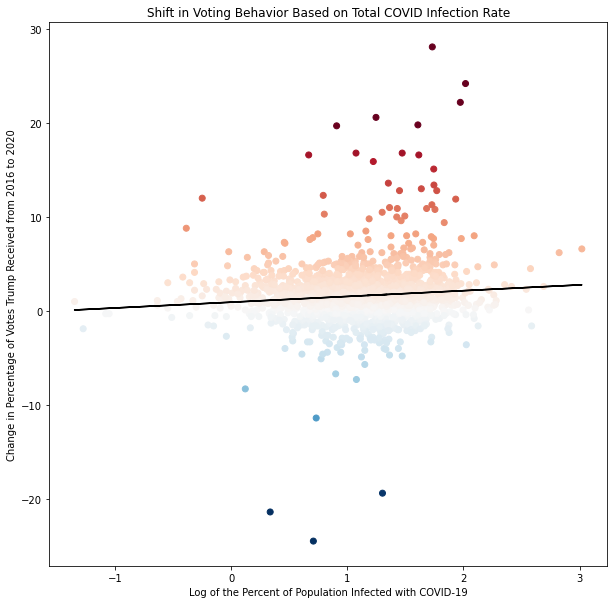

In [ ]:
c = Y
cmap="RdBu_r"
vmin=-20
vmax=20
mid_val=0

plt.figure(figsize=(10,10))
plt.scatter(X, Y, c=c, cmap=cmap, clim=(vmin, vmax), norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax))
plt.plot(X, Y_pred, color='black')
plt.title("Shift in Voting Behavior Based on Total COVID Infection Rate")
plt.ylabel("Change in Percentage of Votes Trump Received from 2016 to 2020")
plt.xlabel("Log of the Percent of Population Infected with COVID-19")

In [ ]:
mod = sm.OLS(Y,X)
fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.220
Model:                            OLS   Adj. R-squared (uncentered):              0.220
Method:                 Least Squares   F-statistic:                              476.5
Date:                Sun, 20 Dec 2020   Prob (F-statistic):                    3.02e-93
Time:                        04:39:23   Log-Likelihood:                         -4255.5
No. Observations:                1689   AIC:                                      8513.
Df Residuals:                    1688   BIC:                                      8518.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Linear Regression COVID cases month before

In [ ]:
Z = merged_data_clean.log_cases_month_before.values.reshape(-1,1)
Y = merged_data_clean.percent_diff_16_to_20.values.reshape(-1,1)
linear_regressor = LinearRegression()
fit = linear_regressor.fit(Z, Y)  
Y_pred = linear_regressor.predict(Z) 

Text(0.5, 0, 'Log of the Percent of Population Infected with COVID-19 (in October 2020)')

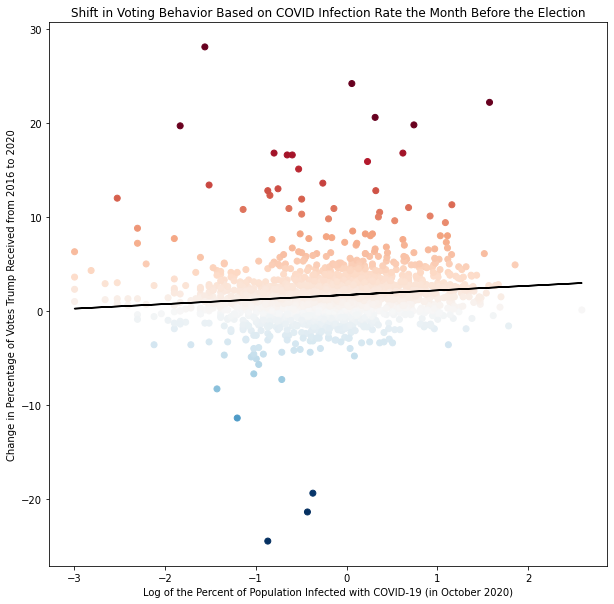

In [ ]:
c = Y
cmap="RdBu_r"
vmin=-20
vmax=20
mid_val=0

plt.figure(figsize=(10,10))
plt.scatter(Z, Y, c=c, cmap=cmap, clim=(vmin, vmax), norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax))
plt.plot(Z, Y_pred, color='black')
plt.title("Shift in Voting Behavior Based on COVID Infection Rate the Month Before the Election")
plt.ylabel("Change in Percentage of Votes Trump Received from 2016 to 2020")
plt.xlabel("Log of the Percent of Population Infected with COVID-19 (in October 2020)")

In [ ]:
mod = sm.OLS(Y,Z)
fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.001
Method:                 Least Squares   F-statistic:                            0.04696
Date:                Sun, 20 Dec 2020   Prob (F-statistic):                       0.828
Time:                        04:39:32   Log-Likelihood:                         -4465.5
No. Observations:                1689   AIC:                                      8933.
Df Residuals:                    1688   BIC:                                      8938.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Linear Regression Total Covid Deaths

In [ ]:
G = merged_data_clean.log_total_deaths.values.reshape(-1,1)
Y = merged_data_clean.percent_diff_16_to_20.values.reshape(-1,1)
linear_regressor = LinearRegression()
fit = linear_regressor.fit(G, Y)  
Y_pred = linear_regressor.predict(G)

Text(0.5, 1.0, 'Shift in Voting Behavior Based on Total COVID Death Rate')

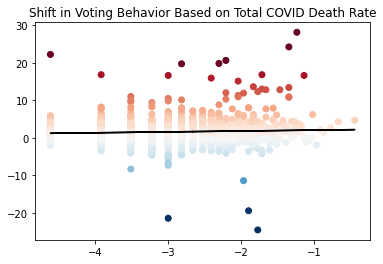

In [ ]:
c = Y
cmap="RdBu_r"
vmin=-20
vmax=20
mid_val=0

plt.scatter(G, Y, c=c, cmap=cmap, clim=(vmin, vmax), norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax))
plt.plot(G, Y_pred, color='black')
plt.title("Shift in Voting Behavior Based on Total COVID Death Rate")

In [ ]:
mod = sm.OLS(Y,G)
fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.196
Model:                            OLS   Adj. R-squared (uncentered):              0.196
Method:                 Least Squares   F-statistic:                              412.0
Date:                Sun, 20 Dec 2020   Prob (F-statistic):                    3.89e-82
Time:                        04:39:36   Log-Likelihood:                         -4281.1
No. Observations:                1689   AIC:                                      8564.
Df Residuals:                    1688   BIC:                                      8570.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Linear Regression COVID deaths month before

In [ ]:
H = merged_data_clean.log_deaths_month_before.values.reshape(-1,1)
Y = merged_data_clean.percent_diff_16_to_20.values.reshape(-1,1)
linear_regressor = LinearRegression()
fit = linear_regressor.fit(H, Y)  
Y_pred = linear_regressor.predict(H) 

Text(0.5, 1.0, 'Shift in Voting Behavior Based on COVID Death Rate the Month Before the Election')

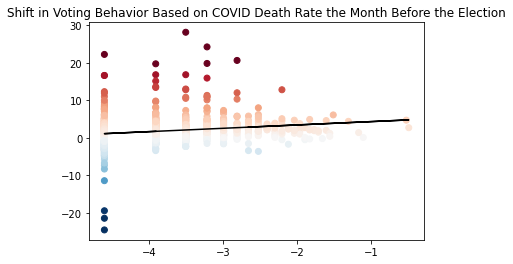

In [ ]:
c = Y
cmap="RdBu_r"
vmin=-20
vmax=20
mid_val=0

plt.scatter(H, Y, c=c, cmap=cmap, clim=(vmin, vmax), norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax))
plt.plot(H, Y_pred, color='black')
plt.title("Shift in Voting Behavior Based on COVID Death Rate the Month Before the Election")

In [ ]:
mod = sm.OLS(Y,H)
fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.190
Model:                            OLS   Adj. R-squared (uncentered):              0.189
Method:                 Least Squares   F-statistic:                              395.5
Date:                Sun, 20 Dec 2020   Prob (F-statistic):                    3.11e-79
Time:                        04:39:47   Log-Likelihood:                         -4287.7
No. Observations:                1689   AIC:                                      8577.
Df Residuals:                    1688   BIC:                                      8583.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Subtask 4: 
Integrating U.S. Geospatial Data and Mapping the Impact of COVID-19 on the 2020 Presidential Election	

In [ ]:
!pip install geopandas

In [ ]:
import geopandas
from shapely.geometry import Point

In [ ]:
#focus on continental USA only
continental_data = merged_data.loc[merged_data['state'] != 'HI']

In [ ]:
points = continental_data.apply(lambda row: Point(float(row.long), float(row.lat)), axis=1)
geom_point_data = continental_data.set_geometry(points)

In [ ]:
geom_point_data.geometry

In [ ]:
xs = [point.x for point in geom_point_data.geometry]
ys = [point.y for point in geom_point_data.geometry]

In [ ]:
state_map = geopandas.read_file("/content/drive/MyDrive/MSSP607Final/cb_2019_us_state_500k.shp")

In [ ]:
state_map.head()

,geometry
0,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."
2,"POLYGON ((-116.04914 48.50205, -116.04913 48.5..."
3,"MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ..."
4,"MULTIPOLYGON (((-76.05015 37.98691, -76.04998 ..."
5,"MULTIPOLYGON (((-79.50795 33.02008, -79.50713 ..."


/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

<Figure size 432x288 with 0 Axes>

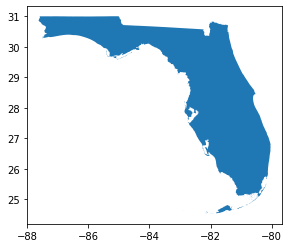

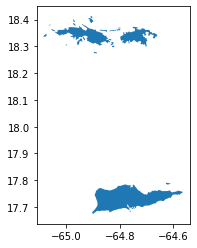

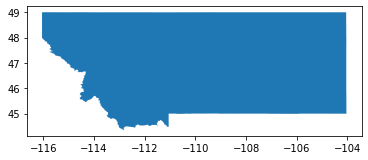

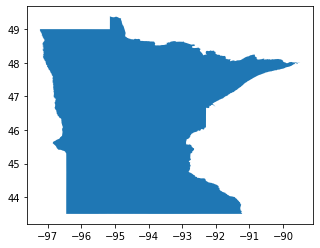

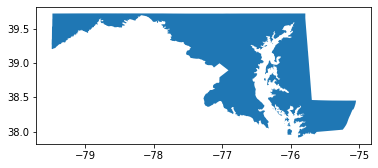

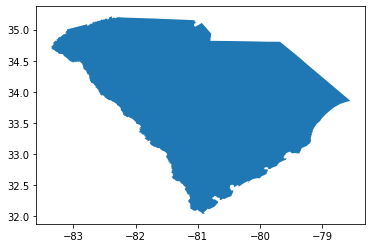

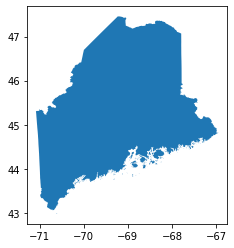

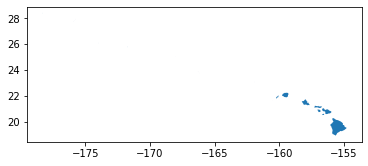

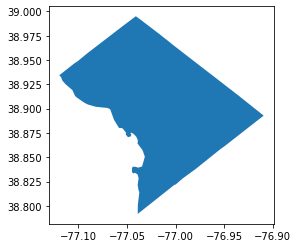

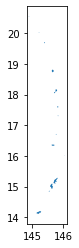

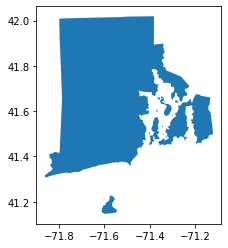

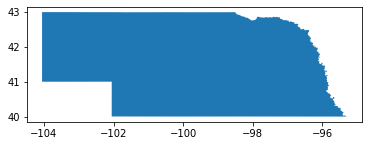

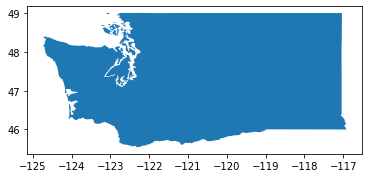

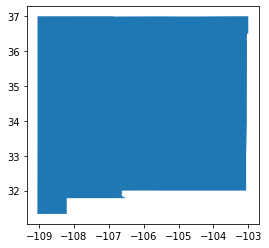

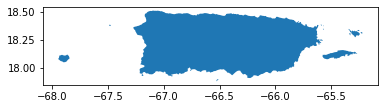

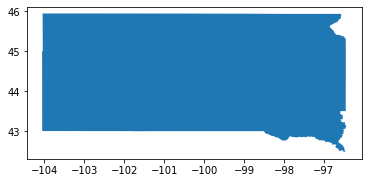

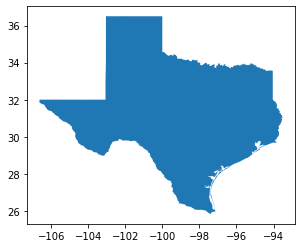

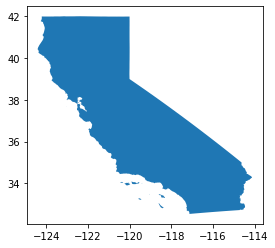

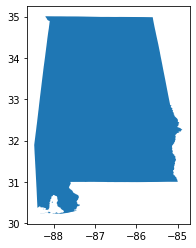

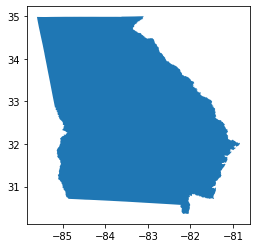

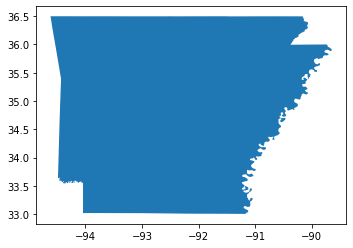

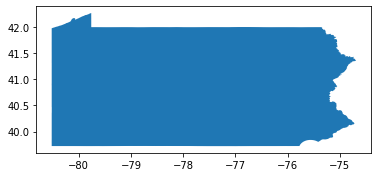

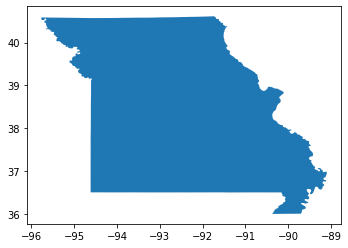

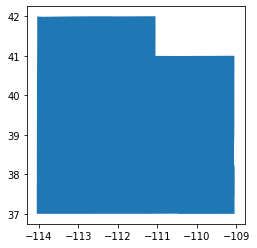

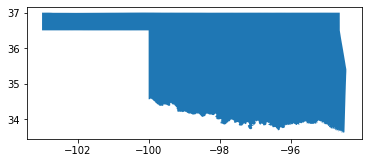

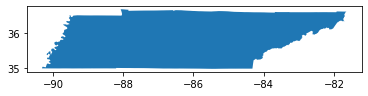

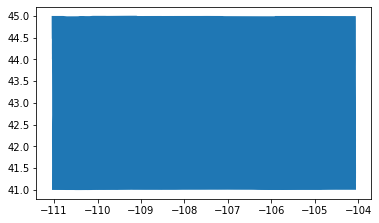

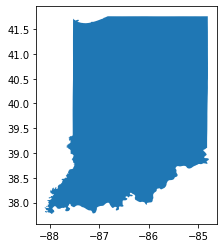

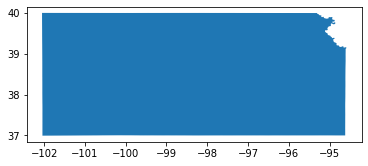

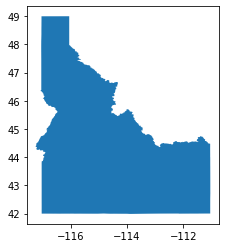

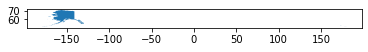

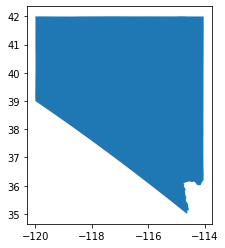

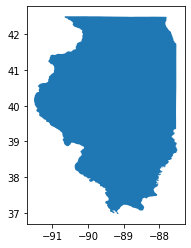

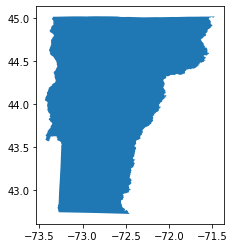

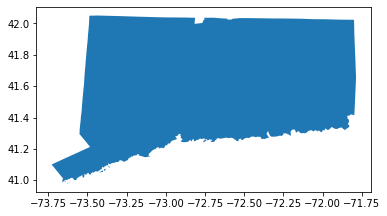

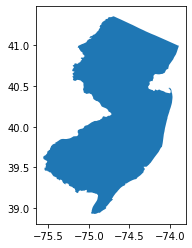

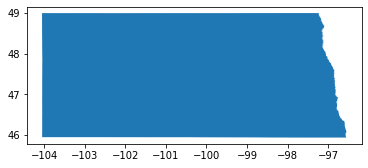

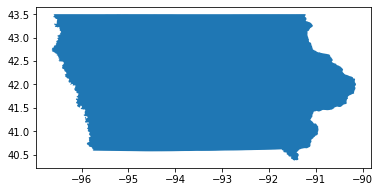

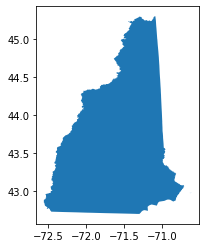

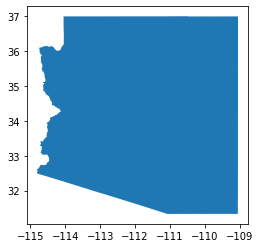

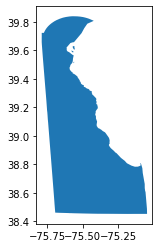

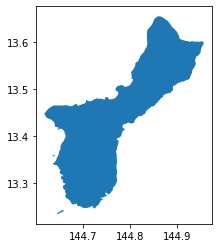

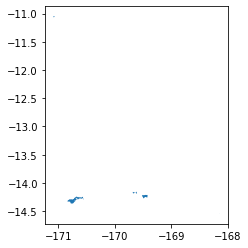

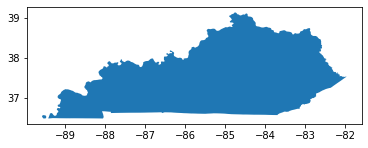

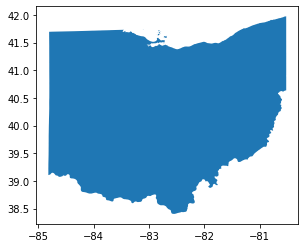

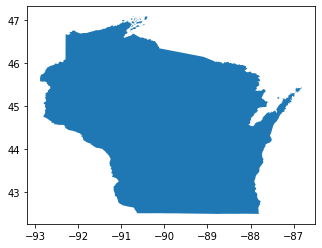

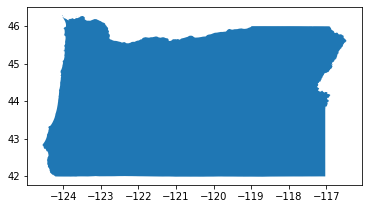

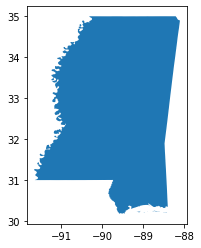

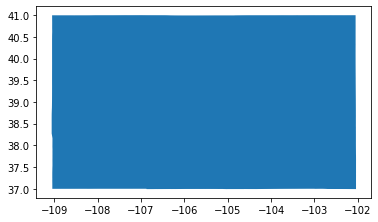

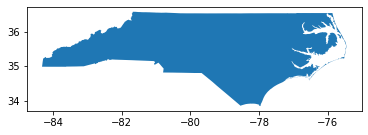

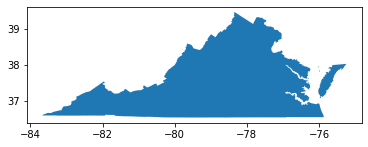

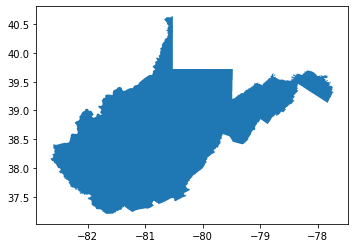

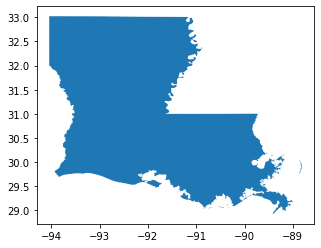

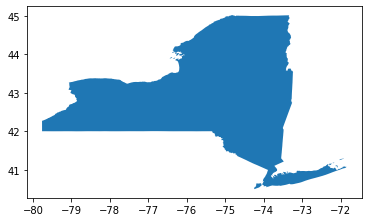

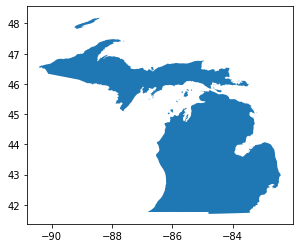

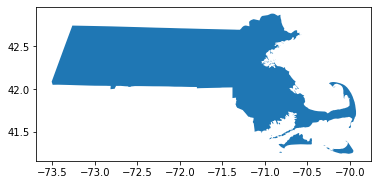

In [ ]:
#The State shape file does not have any text, just shapes.
#I only want states from the continental US, so I need to remove HI and AK.
#State file also contains territories to be removed. 
#I plot each row individually so I can manually identify which ones I don't want.
for i in range(len(state_map.index)):
  plt.figure(i)
  state = state_map.loc[[i], 'geometry']
  state.plot()

In [ ]:
#focus on continental USA only
#territories = 1, 9, 14, 41, 42
#hawaii = 7
#Alaska = 30
irrelevant = [1, 9, 14, 41, 42, 30, 7]

In [ ]:
for index, row in state_map.iterrows():
  if index in irrelevant:
    state_map.drop(index, inplace=True)

## Map Total COVID Cases

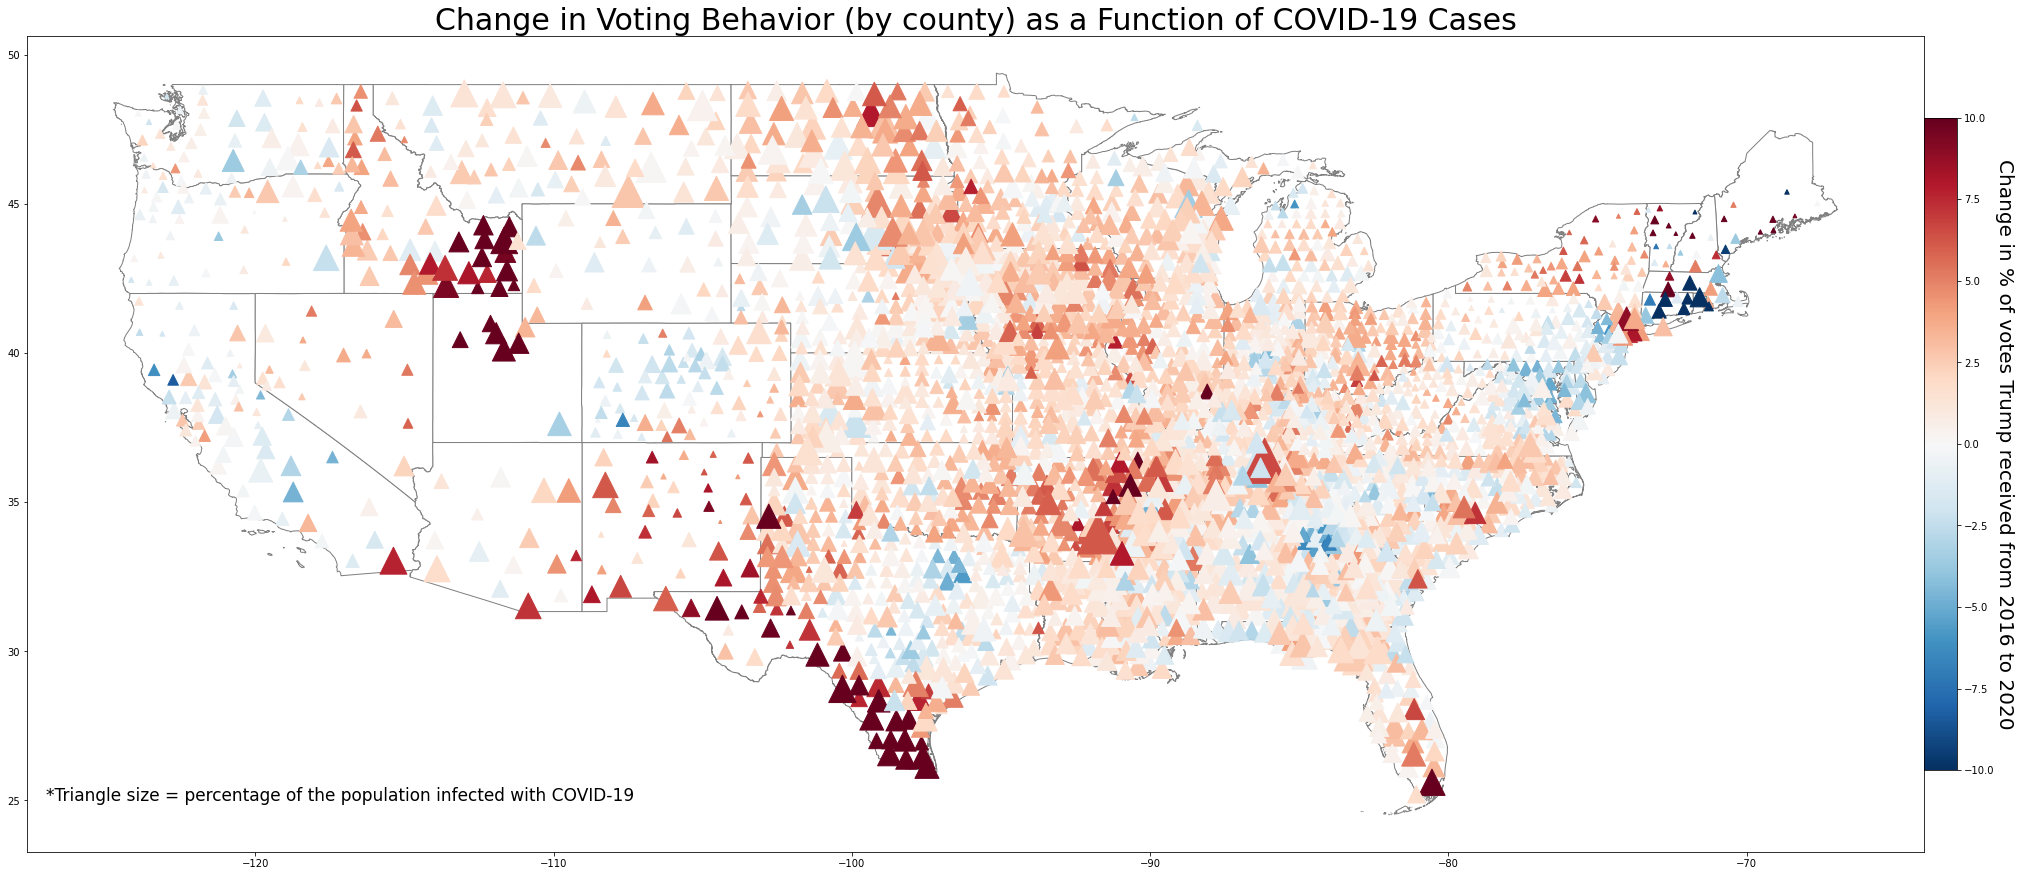

In [ ]:
c = geom_point_data["percent_diff_16_to_20"]
cmap="RdBu_r"
vmin=-10
vmax=10
mid_val=0
sizes=(100*geom_point_data.total_cases_as_percent_population)

ax = state_map.plot(figsize=(40,40), edgecolor='grey', color='white')
plt.scatter(xs, ys, c=c, cmap=cmap, clim=(vmin, vmax),
                     norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax),
                     marker='^', sizes=sizes)
cbar = plt.colorbar(shrink=.3, pad=.0001)
cbar.ax.get_yaxis().labelpad = 100
cbar.ax.set_ylabel('Change in % of votes Trump received from 2016 to 2020', rotation=270, labelpad=20, fontsize=20)
plt.title("Change in Voting Behavior (by county) as a Function of COVID-19 Cases", fontsize=30)

plt.text(-127, 25, "*Triangle size = percentage of the population infected with COVID-19", fontsize=17)

plt.savefig("COVID Map.png")

## Map COVID Cases Month Before

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


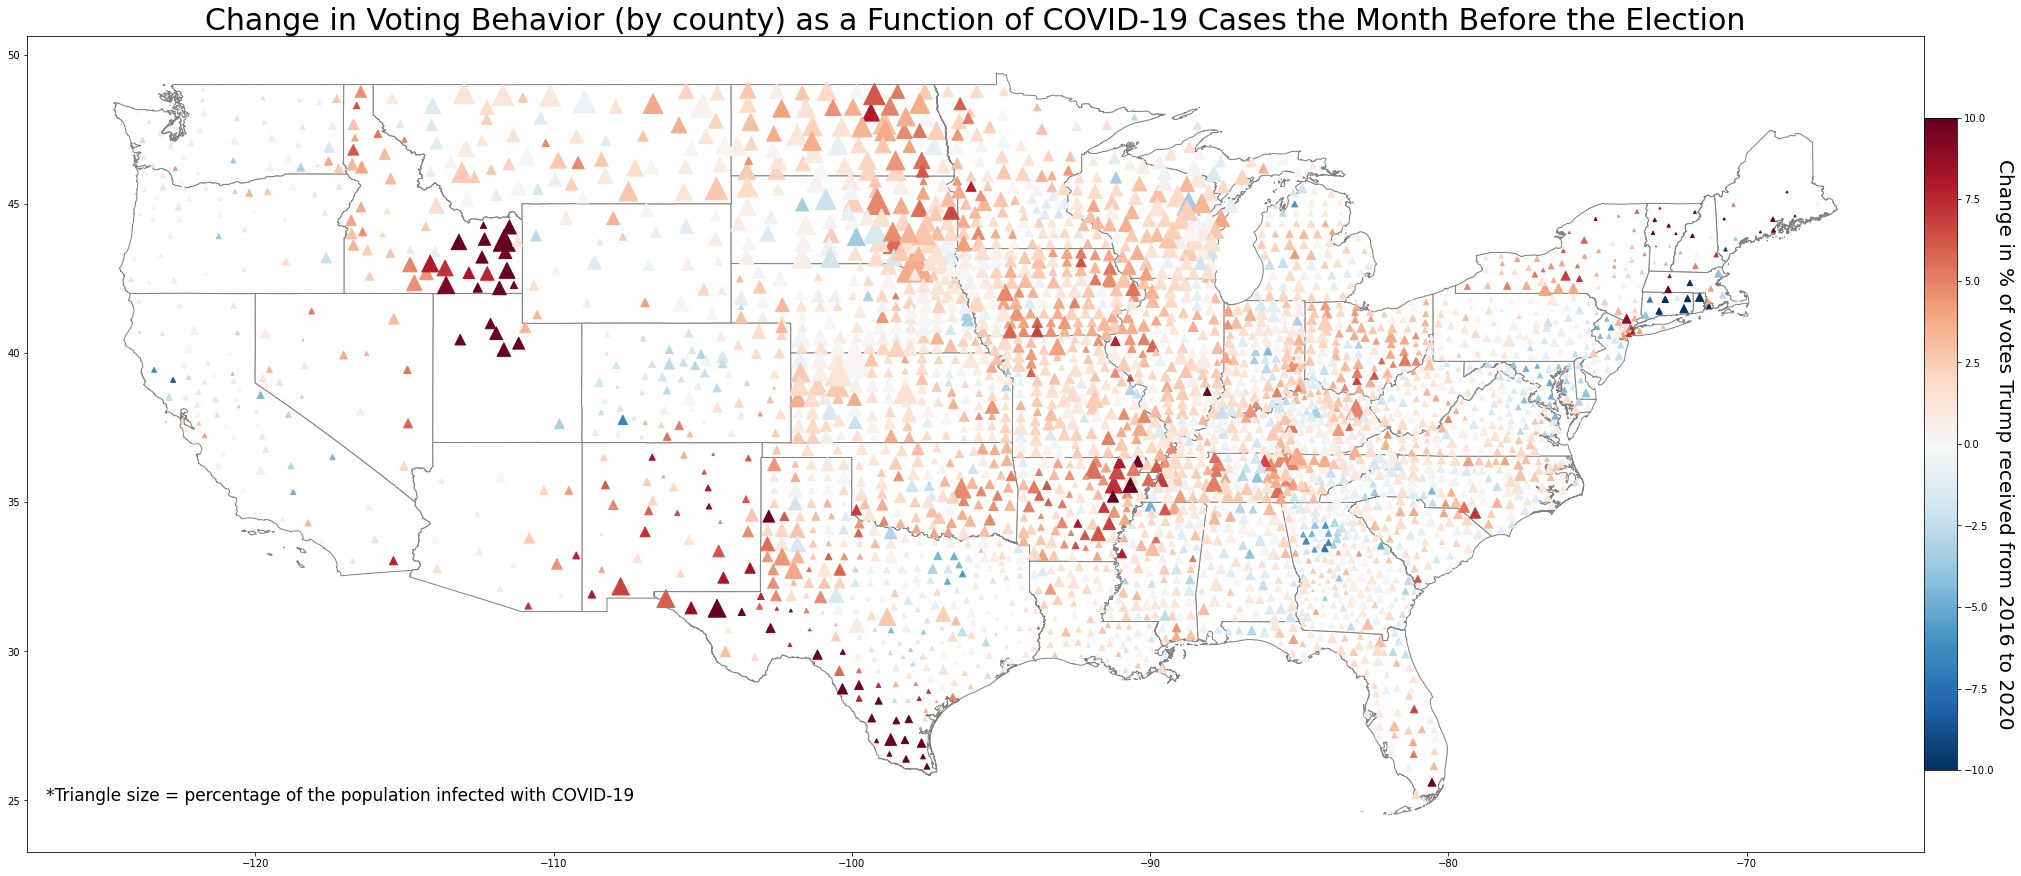

In [ ]:
c = geom_point_data["percent_diff_16_to_20"]
cmap="RdBu_r"
vmin=-10
vmax=10
mid_val=0
sizes=(100*geom_point_data.cases_month_before_as_percent_population)

ax = state_map.plot(figsize=(40,40), edgecolor='grey', color='white')
plt.scatter(xs, ys, c=c, cmap=cmap, clim=(vmin, vmax),
                     norm=MidpointNormalize(midpoint=mid_val, vmin=vmin, vmax=vmax),
                     marker='^', sizes=sizes)
cbar = plt.colorbar(shrink=.3, pad=.0001)
cbar.ax.get_yaxis().labelpad = 100
cbar.ax.set_ylabel('Change in % of votes Trump received from 2016 to 2020', rotation=270, labelpad=20, fontsize=20)
plt.title("Change in Voting Behavior (by county) as a Function of COVID-19 Cases the Month Before the Election", fontsize=30)

plt.text(-127, 25, "*Triangle size = percentage of the population infected with COVID-19", fontsize=17)


plt.savefig("COVID Map Month Before.png")

In [ ]:
files.download("COVID Map.png")
files.download("COVID Map Month Before.png")